In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad as dblquad


In [5]:
class Covariance:

    def __init__(self, cir_params, neuron_params):
        """ 
        """
        self.cir = cir_params
        self.neuron = neuron_params
        self.neuron['12'] = {
            'omega_prime' : (
                self.neuron['1']['omega_prime'] + self.neuron['2']['omega_prime']
                - self.neuron['1']['omega_prime'] * self.neuron['2']['omega_prime']
            )
        }
        
    def xi(self, process, v):
        return np.sqrt(
            1 + 4 * v * self.cir[process]['sigma'] / self.cir[process]['beta']
        )
    
    def psi(self, xi):
        return (1 + xi) / 2
    
    def zeta(self, process, xi, t):
        return (np.exp(xi * t / self.cir[process]['sigma']) - 1) / xi

    def g(self, process, u, v, t):
        """
        """
        xi = self.xi(process, v)
        psi = self.psi(xi)
        zeta = self.zeta(process, xi, t)

        out = self.cir[process]['beta'] * (
            (u / self.cir[process]['beta'] + psi) * np.exp(xi * t / self.cir[process]['sigma'])
            / (1 + self.cir[process]['sigma'] * (u / self.cir[process]['beta'] + psi) * zeta)
            - psi
        )

        return out
    
    def f(self, process, u, v, t):
        """ 
        """
        xi = self.xi(process, v)
        psi = self.psi(xi)
        zeta = self.zeta(process, xi, t)

        out = (
            np.exp(psi * t / self.cir[process]['sigma']) 
            / (1 + self.cir[process]['sigma'] * (u / self.cir[process]['beta'] + psi) * zeta)
        )

        return out

    def g_k(self, process, t_previous, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).
        """
        
        u, v, t = args[0]

        if len(args) == 1:
            # Base case (should be highest value of k for G_{k+1}).
            out = self.g(process, u, v, t - t_previous)
        else:
            out = self.g(process, u + self.g_k(process, t, *args[1:]), v, t - t_previous)

        return out

    def g_n_minus_k(self, process, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).

        # Iterative, cached solution possible here. Avoids repeat computations.
        """
        n = len(args)
        all_g = np.full((n,), np.nan)
        
        # # Precompute n_th term.
        # if n == 1:
        #     # If there is only one term, t1 - 0 = t1.
        #     all_g[-1] = self.g(*args[-1])
        # else:
        #     all_g[-1] = self.g(args[-1][0], args[-1][1], args[-1][2] - args[-2][2])

        # Go in reverse order for remaining elements (beginning from n, ending 
        # with item 2 (corresponding to k+1 when k=1)).
        for i_arg, arg in reversed(list(enumerate(args))[1:]):
            u, v, t = arg

            t_previous = args[i_arg-1][2]
            
            # Handle innermost term edge case.
            if i_arg == n - 1:
                all_g[i_arg] = self.g(process, u, v, t - t_previous)
            else:
                all_g[i_arg] = self.g(process, u + all_g[i_arg + 1], v, t - t_previous)

        all_g = np.concatenate((all_g[1:], np.array([0]))) # initially, i_arg = k, and G_0 = 0, thus need to remove first element

        return all_g
    
    def f_k(self, process, *args):
        """ 
        """
        
        n = len(args)
        
        # all_g_n_minus_k = np.concatenate((self.g_n_minus_k(process, *args[1:]), np.array([0.])))
        all_g_n_minus_k = self.g_n_minus_k(process, *args)
        all_f_k = np.full((n,), np.nan)
        for i_arg in range(n):
            t_previous = 0 if i_arg == 0 else args[i_arg-1][2]
            u, v, t = args[i_arg]
            all_f_k[i_arg] = self.f(process, u + all_g_n_minus_k[i_arg], v, t - t_previous)

        return all_f_k

    def cir_expectation(self, process, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).

        """
        g_n = self.g_k(process, 0, *args)
        all_f_k = self.f_k(process, *args)

        final = (
            np.prod(all_f_k) / (1 + g_n / self.cir[process]['beta'])
        )**self.cir[process]['alpha']

        return final

        # for k in range(n):
        #     u, v, t = args[k]

        #     j = n - k - 1 # Idx for g_n_k

        #     all_f[k] = self.f(u + g_n_k[j], v, t)

    def covariance_kernel(self, s1, s2, t1, t2):
        """ 
        """
        expectation1 = self.cir_expectation(
            '1', (0, 0, s1), (0, self.neuron['1']['omega'], t1)
        )
        
        expectation2 = self.cir_expectation(
            '2', (0, 0, s2), (0, self.neuron['2']['omega'], t2)
        ) #TODO: Check if arguments are really the same
        
        upsilon = (
            self.cir_expectation(
                '12',
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], t2)
            )
            *
            self.cir_expectation(
                '12',
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], t1)
            )
        )
        if s1 >= t1:
            delta_epsilon12 = self.cir_expectation(
                '12', 
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], t1),
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        elif s1 <= s2 and s2 < t1:
            delta_epsilon12 = self.cir_expectation(
                '12', 
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], s2),
                (0, self.neuron['12']['omega_prime'], t1),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        elif s2 <= s1 < t1:
            delta_epsilon12 = self.cir_expectation(
                '12',
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], s1),
                (0, self.neuron['12']['omega_prime'], t1),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        else:
            raise RuntimeError("Unimplemented condition.")

        covariance = expectation1 * expectation2 * delta_epsilon12
        
        return covariance, expectation1, expectation2, delta_epsilon12
    
    # def du_ds(self, neuron_, t, s):
    #     """ 
    #     e.g. neuron_ = '1'
    #     """
    #     if s >= 0:
    #         du_ds = (
    #             self.neuron[neuron_]['v_e'] * (1/self.neuron[neuron_]['tau']) 
    #             * np.exp((s - t)/self.neuron[neuron_]['tau'])
    #         )
    #         # upsilon = self.neuron[neuron_]['v_e'] - self.neuron[neuron_]['v_0']
    #     else:
    #         du_ds = (
    #             (2*(self.neuron[neuron_]['v_e']) - self.neuron[neuron_]['v_0'])
    #             * (1/self.neuron[neuron_]['tau']) 
    #             * np.exp((s - t)/self.neuron[neuron_]['tau'])
    #         )
    #     return du_ds

    def u_measure(self, neuron_, t, s):
        """ 
        e.g. neuron_ = '1'
        """
        if s == 0:
            a = (
                np.exp(-t / self.neuron[neuron_]['tau'])
                * (self.neuron[neuron_]['v_e'] - self.neuron[neuron_]['v_0'])
            )
        else:
            a = 0
        out = (
            np.exp((s-t) / self.neuron[neuron_]['tau']) 
            * self.neuron[neuron_]['v_e'] 
            / self.neuron[neuron_]['tau']
            + a
        )
        return out
    
    def covariance_integrand(self, s1, s2, t1, t2):
        """ 
        """
        kernel, _, _, _ = self.covariance_kernel(s1, s2, t1, t2) 
        return (
            kernel * self.u_measure('1', t1, s1) * self.u_measure('2', t2, s2)
        )
    
    def compute_covariance(self, t1, t2):
        """ 
        """
        return dblquad(self.covariance_integrand, 0, t2, 0, t1, args=(t1, t2))




        

In [6]:
cir_params = {
    '1' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '2' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '12' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    }
}

for key in cir_params.keys():
    cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

neuron_params = {
    '1' : {
        'omega' : 0,
        'omega_prime' : 0,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    },
    '2' : {
        'omega' : 0,
        'omega_prime' : 0,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    }
}




covariance = Covariance(cir_params, neuron_params)

In [7]:
cov = covariance.compute_covariance(5, 5)
print(cov)


(0.0, 0)


In [8]:
# Test expectation for recovery of known cases e.g. when setting parameters to 0.
# Plot delta_12. t1 = t2, varying s2? 

def single_v_t_expectation(covariance, v, t_0, t_n):
    xi =  covariance.xi('1', v)
    sigma = covariance.cir['1']['sigma']
    
    numerator = 4 * xi * np.exp((1 + xi)*(t_n - t_0)/(2*sigma))
    denominator = (1 + xi)**2 * np.exp(xi * (t_n - t_0) / (sigma)) - (1 - xi)**2

    out = (numerator / denominator) ** covariance.cir['1']['alpha']

    return out, xi, sigma


v = 1
t_0 = 0
t_n = 7.1
x_1 = (0, v, 1)
x_2 = (0, v, 3)
x_3 = (0, v, 4)
x_4 = (0, v, 5)
x_5 = (0, v, t_n)

z1 = covariance.cir_expectation('1', x_1, x_2, x_3, x_4, x_5)
z2, xi, sigma = single_v_t_expectation(covariance, v, t_0, t_n)

print(z1, z2)
print(f"xi: {xi}, sigma: {sigma}")



0.010612253070192437 0.010612253070192434
xi: 2.23606797749979, sigma: 1


In [9]:
# To get interactive plots, do the following: install ipympl package and
# restart VS code. Then, run either %matplotlib widget or %matplotlib ipympl in 
# the notebook.
%matplotlib widget

covariance_kernel
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
delta_12
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


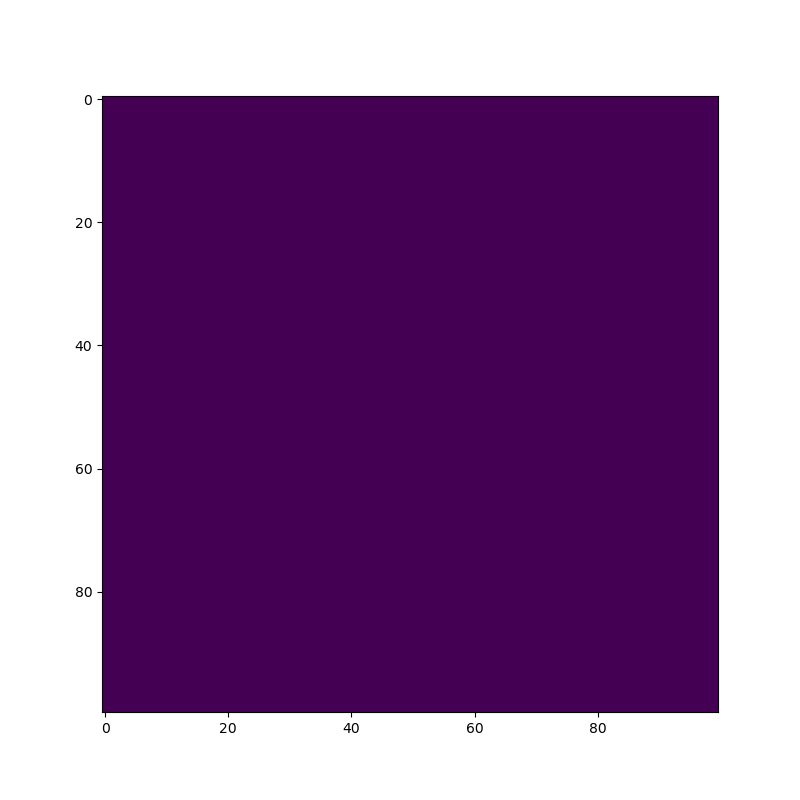

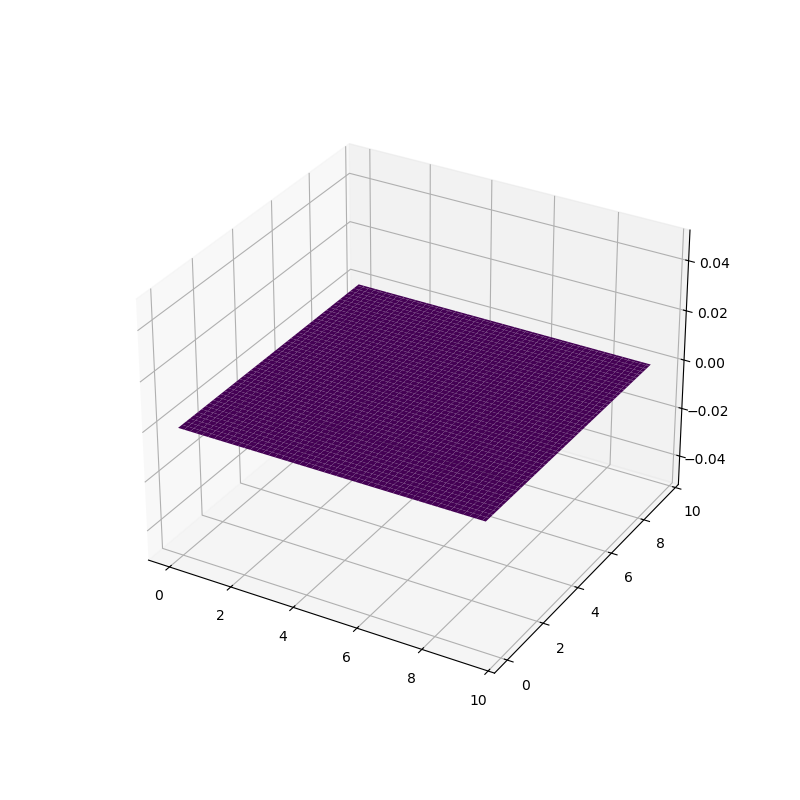

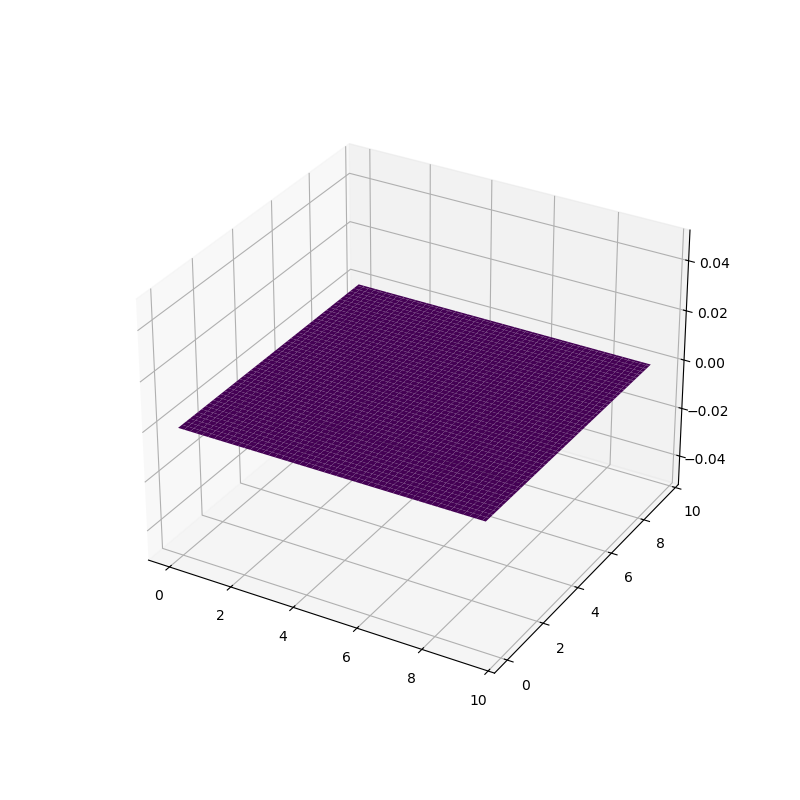

In [10]:
# Plot covariance kernel.
t1 = 10
t2 = t1

num_steps = 100
s_start = 0
s_end = t1 - 0.5
s1_all = np.linspace(s_start, s_end, num_steps)
s2_all = s1_all.copy()

cov_all = np.full((num_steps, num_steps), np.nan)
delta_12_all = np.full(cov_all.shape, np.nan)
for i_s2, s2 in enumerate(s2_all): 
    for i_s1, s1 in enumerate(s1_all):
        cov_all[i_s2, i_s1], _, _, delta_12_all[i_s2, i_s1] = covariance.covariance_kernel(s1, s2, t1, t2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)
ax1.imshow(cov_all)

x_vals, y_vals = np.meshgrid(s1_all, s2_all)
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(x_vals, y_vals, cov_all, linewidth=0, cmap='viridis')
# ax.set_xlabel('s_1')

print("covariance_kernel")
print(cov_all)

fig3 = plt.figure(figsize=(8,8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(x_vals, y_vals, delta_12_all, linewidth=0, cmap='viridis')

print("delta_12")
print(delta_12_all)



In [11]:
out1a = covariance.covariance_kernel(s1_all[24], s2_all[22], t1, t2)
print(out1a)

out1b = covariance.covariance_kernel(s2_all[22], s1_all[24], t1, t2)
print(out1b)


# out2a = covariance.covariance_kernel(s1_all[24], s2_all[21], t1, t2)
# print(out2a)

# out2b = covariance.covariance_kernel(s2_all[21], s1_all[24], t1, t2)
# print(out2b)



(np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0))
(np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0))


In [12]:
# Ensure that G1 and G2 in the covariance kernel C in 1.3.1 match the values 
# computed by evaluating the expectation for a single set of parameters (v, t) 
# with t = t1-s1.

s1 = 10
t1 = 10

out1, _, _ = single_v_t_expectation(covariance, covariance.neuron['1']['omega'], s1, t1)
out2 = covariance.cir_expectation(
            '1', (0, 0, s1), (0, covariance.neuron['1']['omega'], t1) 
        )

print(out1, out2)
print(covariance.neuron['1']['omega'])

1.0 1.0
0


In [13]:
# Check that we recover the deterministic rate case, for fixed r, in the limit 
# of large beta or small sigma.

cir_params = {
    '1' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '2' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '12' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 10,
    }
}

for key in cir_params.keys():
    cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

neuron_params = {
    '1' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    },
    '2' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    }
}

covariance = Covariance(cir_params, neuron_params)

s1 = 0.3
s2 = 8.1
t1 = 10
t2 = t1


def large_beta(covariance, s1, s2, t):
    out = (
        np.exp(
            -covariance.neuron['1']['omega_prime'] * covariance.cir['12']['rate'] * (t - s1)
            -covariance.neuron['2']['omega_prime'] * covariance.cir['12']['rate'] * (t - s2)
        )
        *
        (
            np.exp(
                covariance.neuron['1']['omega_prime']
                * covariance.neuron['2']['omega_prime']
                * covariance.cir['12']['rate']
                * (t - np.max(np.array([s1, s2])))
            )
            - 1
        )
    )
    return out


kernel, _, _, delta_12 = covariance.covariance_kernel(s1, s2, t1, t2)
delta_12_ = large_beta(covariance, s1, s2, t1)

print(delta_12, delta_12_)
print(delta_12 - delta_12_)



0.00010765470323635201 5.2117407316974524e-05
5.553729591937749e-05
